# ML Project Task 2: Dynamics of learning

In [2]:
!pip install --upgrade open_spiel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 32.8 MB/s eta 0:00:00


In [12]:
import numpy as np
import pyspiel
import matplotlib.pyplot as plt
from open_spiel.python.egt import dynamics
from open_spiel.python.egt import visualization
from open_spiel.python.egt.utils import game_payoffs_array
print(pyspiel.registered_names())

['2048', 'amazons', 'backgammon', 'bargaining', 'battleship', 'blackjack', 'blotto', 'breakthrough', 'bridge', 'bridge_uncontested_bidding', 'catch', 'checkers', 'chess', 'cliff_walking', 'clobber', 'coin_game', 'colored_trails', 'connect_four', 'coop_box_pushing', 'coop_to_1p', 'coordinated_mp', 'cursor_go', 'dark_chess', 'dark_hex', 'dark_hex_ir', 'deep_sea', 'efg_game', 'euchre', 'first_sealed_auction', 'gin_rummy', 'go', 'goofspiel', 'hanabi', 'havannah', 'hearts', 'hex', 'kriegspiel', 'kuhn_poker', 'laser_tag', 'leduc_poker', 'lewis_signaling', 'liars_dice', 'liars_dice_ir', 'mancala', 'markov_soccer', 'matching_pennies_3p', 'matrix_cd', 'matrix_coordination', 'matrix_mp', 'matrix_pd', 'matrix_rps', 'matrix_rpsw', 'matrix_sh', 'matrix_shapleys_game', 'mfg_crowd_modelling', 'mfg_crowd_modelling_2d', 'mfg_dynamic_routing', 'mfg_garnet', 'misere', 'morpion_solitaire', 'negotiation', 'nfg_game', 'nim', 'normal_form_extensive_game', 'oh_hell', 'oshi_zumo', 'othello', 'oware', 'pathfind

## Openspiel dynamics with basic replicator equations

## Rock Paper Scissorcs

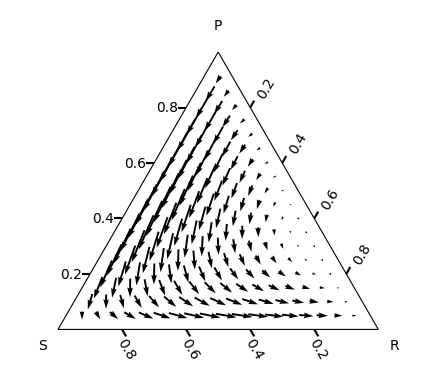

In [3]:
# Define the RPS game
payoff_matrix = np.array([[[0, -0.25, 0.5],
                     [0.25, 0, -0.05],
                     [-0.5, 0.05, 0]],
                     [[0, 0.25, -0.5],
                      [-0.25, 0, 0.05],
                      [0.5, -0.05, 0]]])

# Set up the replicator dynamics
dyn = dynamics.SinglePopulationDynamics(payoff_matrix, dynamics.replicator)
#dyn = dynamics.SinglePopulationDynamics(payoff_matrix, dynamics.boltzmannq)

# Plot the directional field plot
ax = plt.subplot(projection="3x3")

# Add labels to the corner points
ax.text(-0.05, -0.05, 'S', ha='center', va='center')
ax.text(0.5, 0.95, 'P', ha='center', va='center')
ax.text(1.05, -0.05, 'R', ha='center', va='center')

ax.quiver(dyn)

## Dispersion

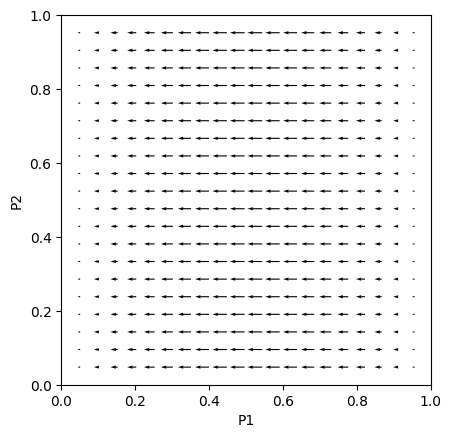

In [45]:
# Define the Dispersion game
game = pyspiel.create_matrix_game([[-1, -1], [1, 1]], [[1, 1], [-1, -1]])
payoff_matrix = game_payoffs_array(game)

# Set up the replicator dynamics
dyn = dynamics.MultiPopulationDynamics(payoff_matrix, dynamics.replicator)
#dyn = dynamics.MultiPopulationDynamics(payoff_matrix, dynamics.boltzmannq)

# Create an object of the Dynamics2x2Axes class
fig, ax = plt.subplots(subplot_kw={'projection': visualization.Dynamics2x2Axes.name})

ax.set_xlabel('P1')
ax.set_ylabel('P2')

# Plot the directional field plot
ax.quiver(dyn, 20)

## Battle Of The Sexes

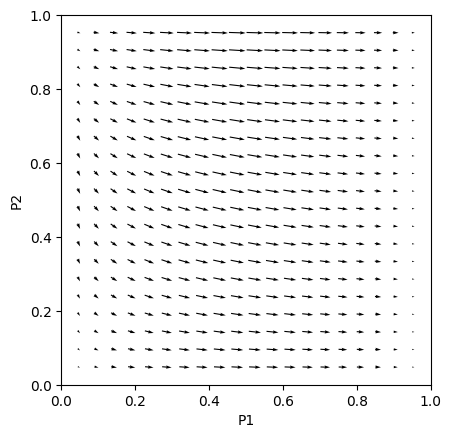

In [46]:
# Define the Battle of the Sexes game
game = pyspiel.create_matrix_game([[3, 2], [0, 0]], [[0, 0], [2, 3]])
payoff_matrix = game_payoffs_array(game)

# Set up the replicator dynamics
dyn = dynamics.MultiPopulationDynamics(payoff_matrix, dynamics.replicator)
#dyn = dynamics.MultiPopulationDynamics(payoff_matrix, dynamics.boltzmannq)

# Create an object of the Dynamics2x2Axes class
fig, ax = plt.subplots(subplot_kw={'projection': visualization.Dynamics2x2Axes.name})

ax.set_xlabel('P1')
ax.set_ylabel('P2')

# Plot the directional field plot
ax.quiver(dyn, 20)

##Prisoner's Dilemma

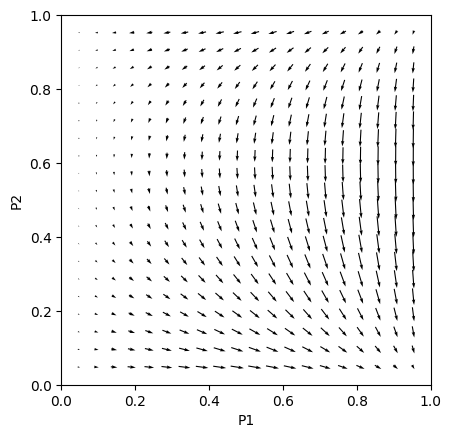

In [27]:
# Define the Prisoner's Dilemma game
game = pyspiel.create_matrix_game([[-1, -1], [-4, 0]], [[0, -4], [-3, -3]])
#game = pyspiel.create_matrix_game([[3, 3], [5, 0]], [[0, 5], [1, 1]])
payoff_matrix = game_payoffs_array(game)

# Set up the replicator dynamics
dyn = dynamics.MultiPopulationDynamics(payoff_matrix, dynamics.replicator)
#dyn = dynamics.MultiPopulationDynamics(payoff_matrix, dynamics.boltzmannq)

# Create an object of the Dynamics2x2Axes class
fig, ax = plt.subplots(subplot_kw={'projection': visualization.Dynamics2x2Axes.name})

ax.set_xlabel('P1')
ax.set_ylabel('P2')

# Plot the directional field plot
ax.quiver(dyn, 20)

## Openspiel dynamics with lenient Boltzmann Q-learning

First we define the lenient Boltzmann Q-learning method.
The formula for the dynamics of lenient Boltzmann can be found in this paper: https://www.jair.org/index.php/jair/article/view/10952/26090. The specific formula that is implemented is formula 10.

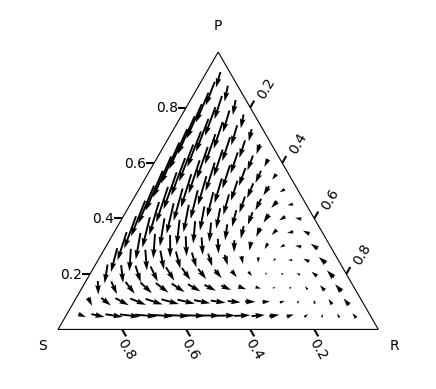

In [9]:
def lenient_boltzmann(state, fitness, temp=0.1):
  """
  Args:
    state: vector representing the probability distribution over the available actions for the agent in the given state.
    fitness: vector representing the expected reward for each action in the current state.
    temp: scalar parameter determining the rate of exploration.
  Returns:
    Time derivative of the population state.
  """
  avg_fitness = state.dot(fitness)
  exploitation = (1. / temp) * state * (fitness - avg_fitness)
  exploration = (np.log(state) - state.dot(np.log(state).transpose()))
  return exploitation - state * exploration

class LenientBoltzmannQDynamics:
    def __init__(self, payoff_matrix, dynamics):
        self.payoff_matrix = payoff_matrix[0]
        self.dynamics = dynamics

    def get_fitness(self, state):
        # Return the fitness by taking the matrix product between the state and the payoff_matrix
        fitness = np.matmul(state, self.payoff_matrix.T)
        return fitness

    def __call__(self, state=None, time=None):
        fitness = self.get_fitness(state)
        return self.dynamics(state, fitness)

# Define the RPS game
payoff_matrix = np.array([[[0, -0.25, 0.5],
                     [0.25, 0, -0.05],
                     [-0.5, 0.05, 0]],
                     [[0, 0.25, -0.5],
                      [-0.25, 0, 0.05],
                      [0.5, -0.05, 0]]])

# Set up the lenient Boltzmann Q-learning dynamics
num_actions = 3
learning_rate = 0.1
temperature = 0.1

# Set up the replicator dynamics
dyn = LenientBoltzmannQDynamics(payoff_matrix, lenient_boltzmann)

# Plot the directional field plot
ax = plt.subplot(projection="3x3")

# Add labels to the corner points
ax.text(-0.05, -0.05, 'S', ha='center', va='center')
ax.text(0.5, 0.95, 'P', ha='center', va='center')
ax.text(1.05, -0.05, 'R', ha='center', va='center')

ax.quiver(dyn)

TypeError: ignored

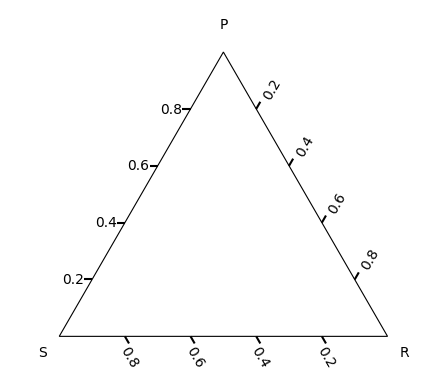

In [36]:
def lenient_boltzmann(q_values, temperature):
    # Compute the action probabilities using the lenient Boltzmann rule
    logits = q_values / temperature
    max_logits = np.max(logits)
    exp_logits = np.exp(logits - max_logits)
    probs = exp_logits / np.sum(exp_logits)
    return probs

class LenientBoltzmannQDynamics:
    def __init__(self, num_actions, learning_rate, temperature):
        self.num_actions = num_actions
        self.learning_rate = learning_rate
        self.temperature = temperature
        self.q_values = np.zeros(num_actions)

    def update(self, action, reward):
        # Update the Q-values using the lenient Boltzmann Q-learning rule
        prob = lenient_boltzmann(self.q_values, self.temperature)
        error = reward - np.dot(self.q_values, prob)
        self.q_values[action] += self.learning_rate * error

    def get_distribution(self):
        # Return the action distribution using the lenient Boltzmann rule
        return lenient_boltzmann(self.q_values, self.temperature)

    def __call__(self, state=None, time=None):
        update()

# Define the RPS game
payoff_matrix = np.array([[[0, -0.25, 0.5],
                     [0.25, 0, -0.05],
                     [-0.5, 0.05, 0]],
                     [[0, 0.25, -0.5],
                      [-0.25, 0, 0.05],
                      [0.5, -0.05, 0]]])

# Set up the lenient Boltzmann Q-learning dynamics
num_actions = 3
learning_rate = 0.1
temperature = 0.1

# Set up the replicator dynamics
dyn = LenientBoltzmannQDynamics(num_actions, learning_rate, temperature)

# Plot the directional field plot
ax = plt.subplot(projection="3x3")

# Add labels to the corner points
ax.text(-0.05, -0.05, 'S', ha='center', va='center')
ax.text(0.5, 0.95, 'P', ha='center', va='center')
ax.text(1.05, -0.05, 'R', ha='center', va='center')

ax.quiver(dyn)

## Rock Paper Scissorcs

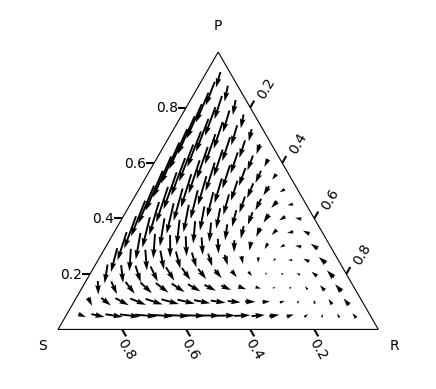

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from open_spiel.python.egt import dynamics
from open_spiel.python.egt import visualization

# Define the RPS game
payoff_matrix = np.array([[[0, -0.25, 0.5],
                     [0.25, 0, -0.05],
                     [-0.5, 0.05, 0]],
                     [[0, 0.25, -0.5],
                      [-0.25, 0, 0.05],
                      [0.5, -0.05, 0]]])

# Set up the replicator dynamics
dyn = dynamics.SinglePopulationDynamics(payoff_matrix, lenient_boltzmann)

# Plot the directional field plot
ax = plt.subplot(projection="3x3")

# Add labels to the corner points
ax.text(-0.05, -0.05, 'S', ha='center', va='center')
ax.text(0.5, 0.95, 'P', ha='center', va='center')
ax.text(1.05, -0.05, 'R', ha='center', va='center')

ax.quiver(dyn)

## Dispersion

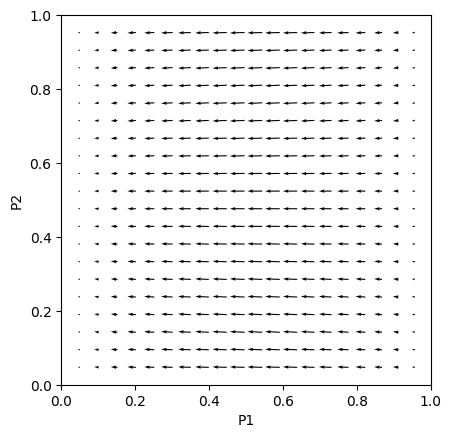

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from open_spiel.python.egt import dynamics
from open_spiel.python.egt import visualization

# Define the Dispersion game
game = pyspiel.create_matrix_game([[-1, -1], [1, 1]], [[1, 1], [-1, -1]])
payoff_matrix = game_payoffs_array(game)

# Set up the replicator dynamics
dyn = dynamics.MultiPopulationDynamics(payoff_matrix, lenient_boltzmann)

# Create an object of the Dynamics2x2Axes class
fig, ax = plt.subplots(subplot_kw={'projection': visualization.Dynamics2x2Axes.name})

ax.set_xlabel('P1')
ax.set_ylabel('P2')

# Plot the directional field plot
ax.quiver(dyn, 20)

## Battle of the sexes

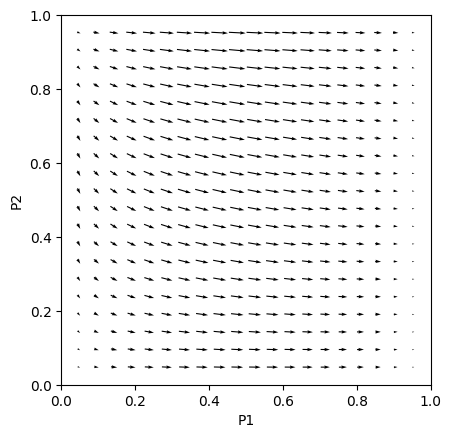

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from open_spiel.python.egt import dynamics
from open_spiel.python.egt import visualization

# Define the Battle of the Sexes game
game = pyspiel.create_matrix_game([[3, 2], [0, 0]], [[0, 0], [2, 3]])
payoff_matrix = game_payoffs_array(game)

# Set up the replicator dynamics
dyn = dynamics.MultiPopulationDynamics(payoff_matrix, lenient_boltzmann)

# Create an object of the Dynamics2x2Axes class
fig, ax = plt.subplots(subplot_kw={'projection': visualization.Dynamics2x2Axes.name})

ax.set_xlabel('P1')
ax.set_ylabel('P2')

# Plot the directional field plot
ax.quiver(dyn, 20)

## Prisoner's Dilemma

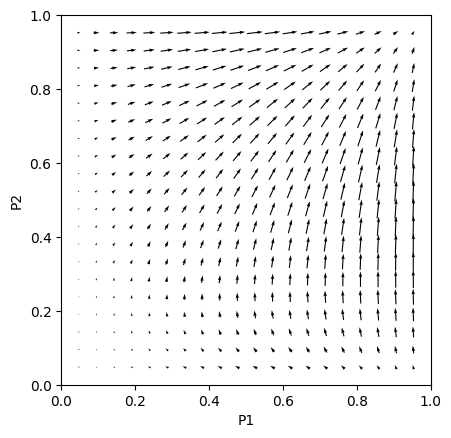

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from open_spiel.python.egt import dynamics
from open_spiel.python.egt import visualization

# Define the Prisoner's Dilemma game
game = pyspiel.create_matrix_game([[-1, -1], [-4, 0]], [[0, -4], [-3, -3]])
payoff_matrix = game_payoffs_array(game)

# Set up the replicator dynamics
dyn = dynamics.MultiPopulationDynamics(payoff_matrix, lenient_boltzmann)

# Create an object of the Dynamics2x2Axes class
fig, ax = plt.subplots(subplot_kw={'projection': visualization.Dynamics2x2Axes.name})

ax.set_xlabel('P1')
ax.set_ylabel('P2')

# Plot the directional field plot
ax.quiver(dyn, 20)

In [32]:
import numpy as np
import matplotlib.pyplot as plt

import pyspiel
import open_spiel.python.algorithms.nash_solver as nash_solver
import open_spiel.python.algorithms.deterministic_policy_gradient as dpg
import open_spiel.python.egt.visualization as egt_vis
import open_spiel.python.egt.dynamics as dynamics

# Define the lenient Boltzmann formula
def lenient_boltzmann(state, fitness):
    temp = 0.1
    avg_fitness = state.dot(fitness)
    exploitation = (1. / temp) * state * (fitness - avg_fitness)
    exploration = (np.log(state) - state.dot(np.log(state).transpose()))
    return exploitation - state * exploration

# Define the game and initial state
game = pyspiel.load_game("matrix_mp")
initial_state = game.new_initial_state()

# Define the fitness function for each player
def get_fitness(state):
    return np.array([state.player_score(player) for player in [0, 1]])

# Define the dynamics for each player using the lenient Boltzmann Q-learning
def boltzmann_dynamics(state, player):
    payoff_tensor = np.array(state.returns())
    num_actions = payoff_tensor.shape[player]
    state_vector = np.array([state.action_prob(player, action) for action in range(num_actions)])
    fitness_vector = get_fitness(state)
    q_values = np.zeros(num_actions)
    for action in range(num_actions):
        new_state = state.clone()
        new_state.apply_action(player, action)
        q_values[action] = payoff_tensor[player][action] + state.player_reward(player) + lenient_boltzmann(state_vector, q_values)[action]
    prob_vector = np.exp(q_values / temp)
    prob_vector /= np.sum(prob_vector)
    return prob_vector

# Define the replicator dynamics using the Boltzmann Q-learning dynamics
def replicator_dynamics(state):
    dynamics.SinglePopulationDynamics(len(initial_state), state, [boltzmann_dynamics])

# Plot the directional field plots
x, y = np.meshgrid(np.linspace(0, 1, 21), np.linspace(0, 1, 21))
dx = lenient_boltzmann(x, y)[0]
dy = lenient_boltzmann(x, y)[1]
fig, ax = plt.subplots()
ax.quiver(x, y, dx, dy)
ax.set_xlabel("Player 1")
ax.set_ylabel("Player 2")
ax.set_title("Directional Field Plot for Lenient Boltzmann Q-Learning Dynamics")
plt.show()

ModuleNotFoundError: ignored